# Projet ALYRA - Classification de champignons 

# 1. Introduction

# 2. EDA

#### 2.1 Chargement du dataset

In [1]:
# Import des librairies
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

# Import des modules TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import imagehash
from PIL import Image


Charger le dataset mushroom classification

In [2]:
dataset_path = "./dataset/" 
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print("Classes trouvées :", classes)

Classes trouvées : ['Amanita muscaria', 'Coprinus comatus', 'Laetiporus sulphureus']


Rechercher d'éventuelles images corrompues

In [3]:
corrupted_count = 0

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    for img_name in os.listdir(class_path):
        try:
            Image.open(os.path.join(class_path, img_name)).verify()
        except:
            corrupted_count += 1

print("Nombre d'images corrompues :", corrupted_count)

Nombre d'images corrompues : 0


Supprimer les doublons

In [4]:
def remove_duplicates(dataset_path, classes, threshold=5):
    total_removed = 0
    
    for cls in classes:
        class_path = os.path.join(dataset_path, cls)
        images = [f for f in os.listdir(class_path) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        hashes = {}
        removed = 0
        
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            try:
                img = Image.open(img_path)
                h = imagehash.average_hash(img)
                
                # Chercher un hash similaire
                is_duplicate = False
                for existing_hash in hashes:
                    if h - existing_hash <= threshold:
                        os.remove(img_path)  # Supprimer le doublon
                        removed += 1
                        is_duplicate = True
                        break
                
                if not is_duplicate:
                    hashes[h] = img_path
            except:
                pass
        
        print(f"{cls:20} : {len(images)} → {len(images)-removed} (-{removed} doublons)")
        total_removed += removed
    
    print(f"\nTotal doublons supprimés : {total_removed} images")

# Lancer la suppression
remove_duplicates(dataset_path, classes, threshold=5)

Amanita muscaria     : 2152 → 2152 (-0 doublons)
Coprinus comatus     : 1509 → 1509 (-0 doublons)
Laetiporus sulphureus : 2259 → 2259 (-0 doublons)

Total doublons supprimés : 0 images


#### 2.2 Récupérer et afficher le nombre d'images par classe

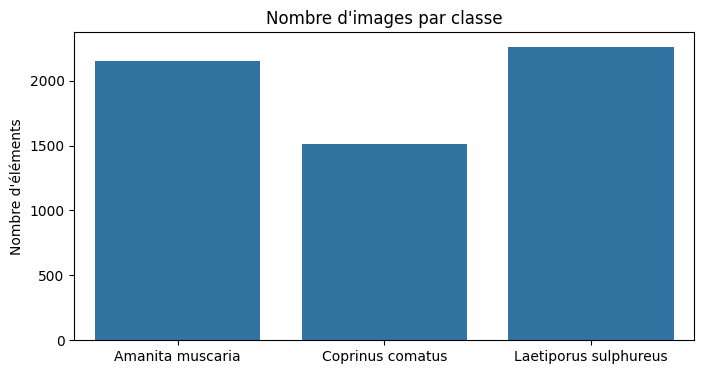

In [5]:
image_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes}

plt.figure(figsize=(8,4))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))
plt.title("Nombre d'images par classe")
plt.ylabel("Nombre d'éléments")
plt.show()

#### 2.3 Afficher quelques images tirées de chaque classe

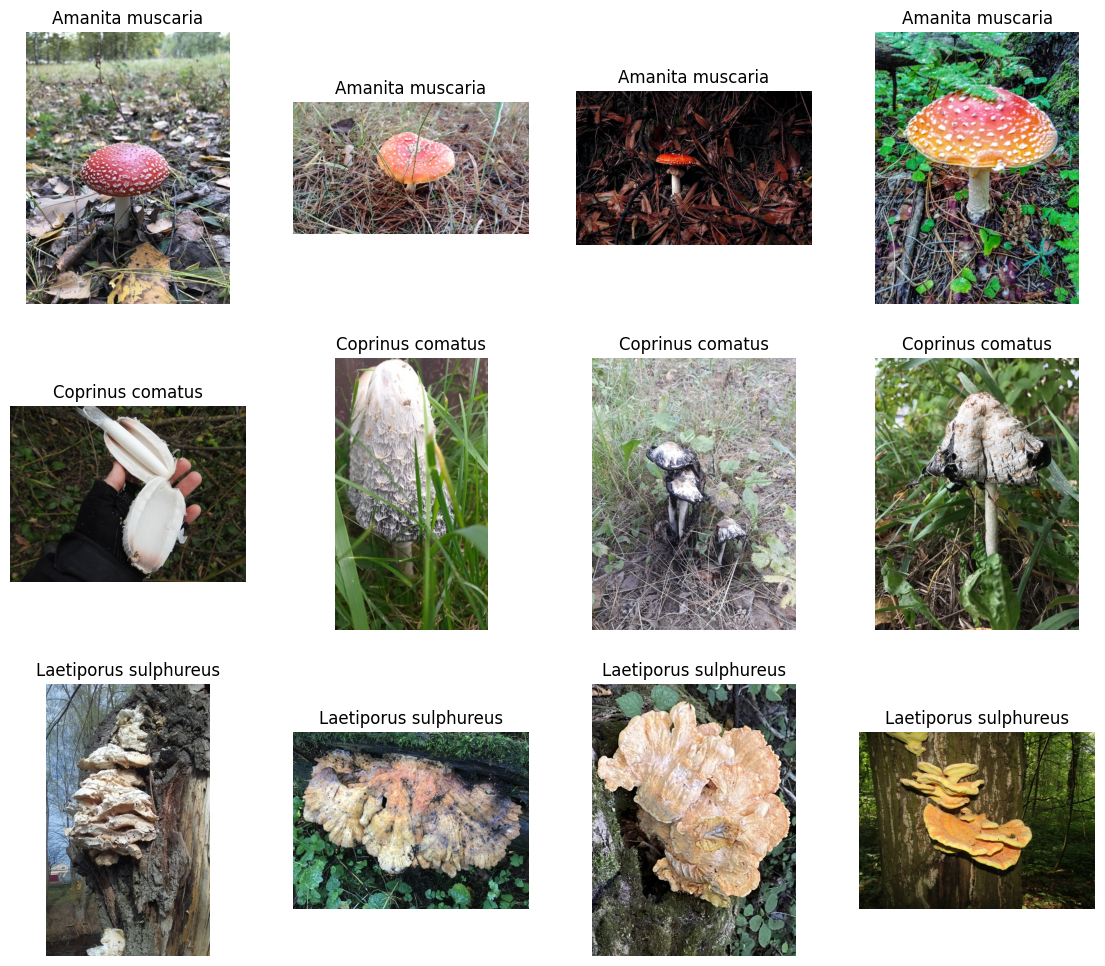

In [6]:
def display_samples(dataset_path, classes, n=4):
    plt.figure(figsize=(14, 4 * len(classes)))

    for idx, cls in enumerate(classes):
        class_path = os.path.join(dataset_path, cls)
        images = os.listdir(class_path)
        samples = random.sample(images, min(n, len(images)))

        for i, img_name in enumerate(samples):
            img = Image.open(os.path.join(class_path, img_name))
            plt.subplot(len(classes), n, idx*n + i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(cls)

    plt.show()

display_samples(dataset_path, classes)

#### 2.4 Afficher un inventaire des résolutions d’images du dataset

Récupérer les résolutions

In [7]:
# Récupérer les tailles (width, height)
sizes = []   

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    for img_name in os.listdir(class_path):
        try:
            with Image.open(os.path.join(class_path, img_name)) as img:
                sizes.append((img.width, img.height, cls)) # (width, height, class)
        except:
            pass

widths  = [s[0] for s in sizes]
heights = [s[1] for s in sizes]


# Créer une liste des résolutions
# On ignore la classe et on garde seulement (width, height)
resolutions = [(s[0], s[1]) for s in sizes]
# Compter combien de fois chaque résolution apparaît
resolution_counts = Counter(resolutions)
print(f"Nombre de résolutions différentes: {len(resolution_counts)}")

Nombre de résolutions différentes: 416


Afficher les 10 résolutions les plus courantes

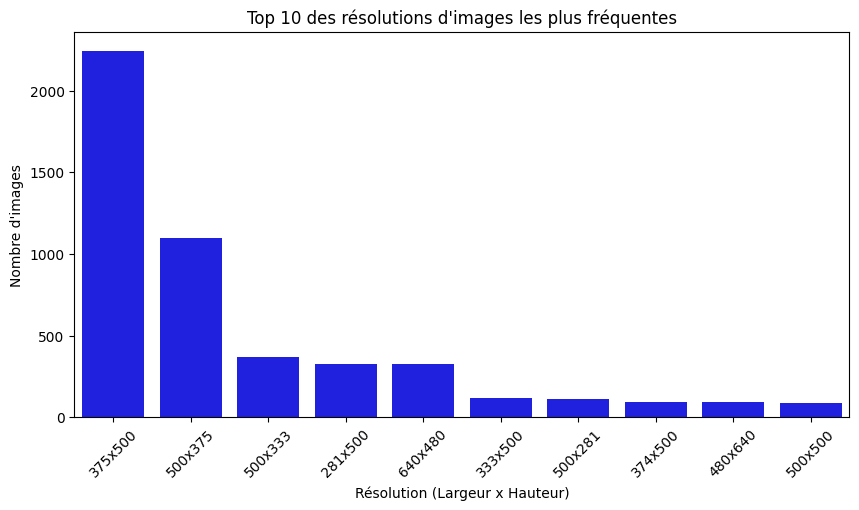

In [8]:
# Trier par fréquence décroissante pour avoir les 10 résoluttions les plus courantes en premier
sorted_resolutions = resolution_counts.most_common(10)
# Récupérer la largeur et la hauteur pour l'affichage
top_resolutions = [f"{w}x{h}" for (w,h), c in sorted_resolutions]
top_counts = [c for (w,h), c in sorted_resolutions]

top_df = pd.DataFrame({
    "resolution": top_resolutions,
    "count": top_counts
})

plt.figure(figsize=(10,5))
sns.barplot(data=top_df, x="resolution", y="count", color="blue") 
plt.xticks(rotation=45)
plt.title("Top 10 des résolutions d'images les plus fréquentes")
plt.xlabel("Résolution (Largeur x Hauteur)")
plt.ylabel("Nombre d'images")
plt.show()

- Conclusion: 

# 3. Pre-processing

#### 3.1 Paramètres de preprocessing

In [9]:
IMG_SIZE = (128, 128)  # Pour redimensionner toutes les images à 128x128
classes_dict = {cls: idx for idx, cls in enumerate(classes)}  # Mapping classe -> int

X = []  # Images
y = []  # Labels

#### 3.2 Redimensionnements et normalisations des images

In [10]:
# Lecture et traitement de chaque image
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    for img_name in os.listdir(class_path):
        try:
            img = Image.open(os.path.join(class_path, img_name)).convert('RGB')
            # Redimensionnement à (128,128)
            img = img.resize(IMG_SIZE) 
            # Normalisation [0,1] pour faciliter l’entraînement du CNN
            img_array = np.array(img) / 255.0  
            X.append(img_array)
            # Ajouter le label
            y.append(classes_dict[cls])
        except:
            pass

X = np.array(X)
y = np.array(y)

print(f"Shape des données : X={X.shape}, y={y.shape}")

Shape des données : X=(5920, 128, 128, 3), y=(5920,)


#### 3.3 Transformation des labels on one-hot encoding (En prévision de l'ajout de nouvelles classes)

In [11]:
USE_BINARY = False  # True pour binaire, False pour one-hot

if USE_BINARY and len(classes) == 2:
    print("Mode binaire activé")
else:
    print("Mode one-hot activé")
    y = to_categorical(y, num_classes=len(classes))

print(f"Forme des labels après encodage : y={y.shape}")

Mode one-hot activé
Forme des labels après encodage : y=(5920, 3)


#### 3.4 Séparation train/test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (4736, 128, 128, 3), (4736, 3)
Test set: (1184, 128, 128, 3), (1184, 3)


# 4. Definition du modèle et régularisation

#### 4.1 Définir le modèle CNN from scratch

In [13]:
model = Sequential([

    # Extraction de features basique avec des couches convolutionnelles et de pooling
    # Crée 32 filtres de taille 3×3 qui détectent des patterns simples (bords, textures)
    # Input : image 128×128 RGB → Output : 126×126×32
    Input(shape=(128, 128, 3)), Conv2D(32, (3,3), activation='relu'),
    # Réduit la taille par 2 → 63×63×32
    # Garde seulement l'info importante
    MaxPooling2D((2,2)),


    # Features intermédiaires
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    # Features complexes
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    # Flatten et fully connected
    Flatten(), # Transforme en vecteur 1D : 14×14×128 = 25,088 valeurs
    Dense(128, activation='relu'), # Couche dense : combine toutes les features
    Dropout(0.5),  # Régularisation pour éviter overfitting -> Désactive 50% des neurones pour éviter overfitting
    Dense(y.shape[1], activation='softmax')  # Sortie pour classification (probabilités par classe)
])


# 5. Compilation et entrainement

#### 5.1 Compiler le modèle

In [14]:
model.compile(
    optimizer='adam',
    # Loss function adaptée pour multi-classes et one-hote encoding des labels
    loss='categorical_crossentropy', # categorical_crossentropy = car on fait du to_categorical()
    metrics=['accuracy']
)

# Afficher l'architecture du modèle
print("Résumé de l'architecture du modèle :")
model.summary()


Résumé de l'architecture du modèle :


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

#### 5.2 Entrainer le modèle

In [15]:
history = model.fit(
    X_train, y_train,
    epochs=25, # On peux augmenter le nombre d'epochs selon la convergence
    batch_size=32,
    validation_split=0.2 # 20% du train utilisé pour validation
)

Epoch 1/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 146ms/step - accuracy: 0.7355 - loss: 0.6009 - val_accuracy: 0.8977 - val_loss: 0.3007
Epoch 2/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 0.8865 - loss: 0.3200 - val_accuracy: 0.9114 - val_loss: 0.2496
Epoch 3/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 0.9087 - loss: 0.2547 - val_accuracy: 0.9209 - val_loss: 0.2092
Epoch 4/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - accuracy: 0.9227 - loss: 0.2205 - val_accuracy: 0.9272 - val_loss: 0.2101
Epoch 5/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 0.9361 - loss: 0.1769 - val_accuracy: 0.9272 - val_loss: 0.1859
Epoch 6/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 0.9382 - loss: 0.1545 - val_accuracy: 0.9388 - val_loss: 0.1709
Epoch 7/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 18s 154ms/step - accuracy: 0.9488 - loss: 0.1407 - val_accuracy: 0.9367 - val_loss: 0.1904
Epoch 8/25
119/119 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - accuracy: 0.9575 - loss: 0

Choix du batch_size:

```python
batch_size = 16   # Petit : apprentissage précis mais lent
batch_size = 32   # ✅ Standard : bon équilibre (utilisé ici))
batch_size = 64   # Moyen : plus rapide, moins précis
batch_size = 128  # Grand : très rapide mais peut être instable
```

Visualiser l'évolution de l'entrainement

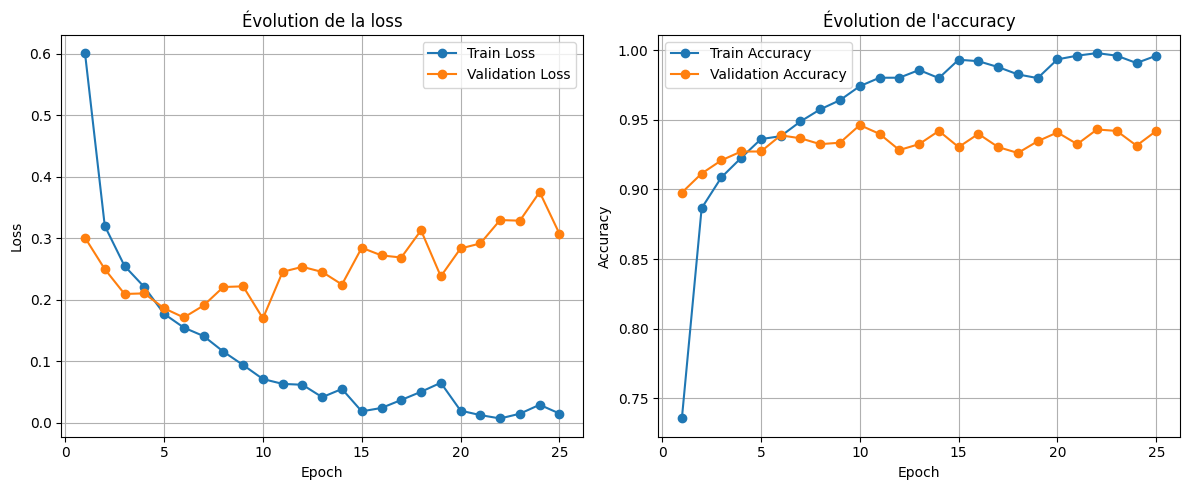

In [16]:
import matplotlib.pyplot as plt

# Extraire les valeurs depuis l'historique
train_loss = history.history['loss']
val_loss   = history.history['val_loss']
train_acc  = history.history['accuracy']
val_acc    = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Graphe 1 : Loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Évolution de la loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Graphe 2 : Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title("Évolution de l'accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


#### 5.3 Évaluation finale sur le test set

In [17]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print(f"Train accuracy : {history.history['accuracy'][-1]:.4f}")
print(f"Val accuracy   : {history.history['val_accuracy'][-1]:.4f}")
print(f"Test accuracy  : {test_acc:.4f}") 

Train accuracy : 0.9960
Val accuracy   : 0.9420
Test accuracy  : 0.9358


#### 5.3 Faire des prédictions

Preparer les données pour l'évaluation

In [18]:
y_pred_probs = model.predict(X_test) 
y_pred = np.argmax(y_pred_probs, axis=1) 
y_true = np.argmax(y_test, axis=1) 

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


# 6. Evaluation

#### 6.1 Matrice de confusion

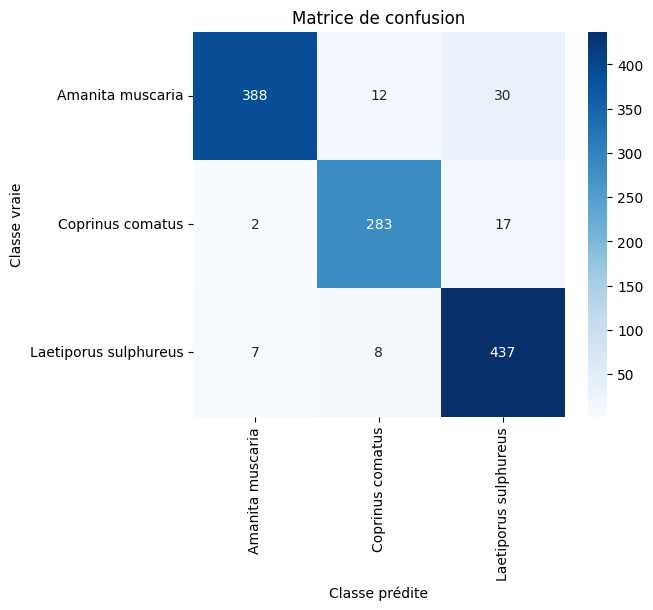

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe prédite')
plt.ylabel('Classe vraie')
plt.title('Matrice de confusion')
plt.show()

#### 6.2 Rapport de classification

In [20]:
print(classification_report(y_true, y_pred, target_names=classes))

                       precision    recall  f1-score   support

     Amanita muscaria       0.98      0.90      0.94       430
     Coprinus comatus       0.93      0.94      0.94       302
Laetiporus sulphureus       0.90      0.97      0.93       452

             accuracy                           0.94      1184
            macro avg       0.94      0.94      0.94      1184
         weighted avg       0.94      0.94      0.94      1184



#### 6.3 Exemples d'erreurs


Nombre d'erreurs : 76/1184 (6.4%)


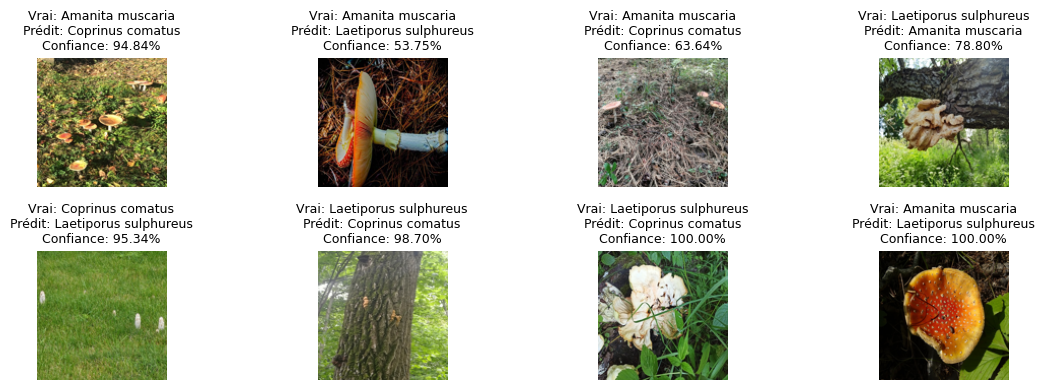

In [21]:
# Trouve les indices des prédictions incorrectes
errors = np.where(y_pred != y_true)[0]

print(f"\nNombre d'erreurs : {len(errors)}/{len(y_test)} ({len(errors)/len(y_test)*100:.1f}%)")

# Afficher 8 exemples d'erreurs
if len(errors) > 0:
    plt.figure(figsize=(12, 4))
    for i, idx in enumerate(errors[:8]):
        plt.subplot(2, 4, i+1)
        plt.imshow(X_test[idx])
        plt.axis('off')
        plt.title(f"Vrai: {classes[y_true[idx]]}\n"
                  f"Prédit: {classes[y_pred[idx]]}\n"
                  f"Confiance: {y_pred_probs[idx].max():.2%}", 
                  fontsize=9)
    plt.tight_layout()
    plt.show()

# 7. Hyperparameter Tuning & Fine-tuning du modèle


#### 7.1 Analyse des résultats du modèle baseline

**Observations du modèle initial :**
- Test accuracy : 93.55%
- Overfitting léger observé après epoch 6-7
- Val_loss oscille au lieu de converger

**Axes d'amélioration identifiés :**
1. Utiliser Early Stopping pour arrêter automatiquement
2. Augmenter la régularisation (Dropout)
3. Ajouter Data Augmentation

#### 7.2 Amélioration 1 : Early Stopping

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

# Recréer le modèle from scratch
model_v2 = Sequential([
    Input(shape=(128, 128, 3)), Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model_v2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Créer le callback Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Entraîner le nouveau modèle
print("Entraînement avec Early Stopping...")
history_v2 = model_v2.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

# Évaluation
train_loss_v2, train_acc_v2 = model_v2.evaluate(X_train, y_train, verbose=0)
test_loss_v2, test_acc_v2 = model_v2.evaluate(X_test, y_test, verbose=0)

print(f"\nRésultats avec Early Stopping :")
print(f"Train accuracy : {train_acc_v2:.4f}")
print(f"Test accuracy  : {test_acc_v2:.4f}")
print(f"Écart (overfitting) : {(train_acc_v2 - test_acc_v2)*100:.2f}%")
print(f"Amélioration vs baseline : {(test_acc_v2 - test_acc)*100:+.2f}%")

Entraînement avec Early Stopping...
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 7.

Résultats avec Early Stopping :
Train accuracy : 0.9700
Test accuracy  : 0.9333
Écart (overfitting) : 3.67%
Amélioration vs baseline : -0.25%


#### 7.3 Amélioration 2 : Modèle avec plus de régularisation

In [23]:
# Nouveau modèle avec Dropout plus élevé
model_v3 = Sequential([
    Input(shape=(128, 128, 3)), Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.6),
    Dense(len(classes), activation='softmax')
])

model_v3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Entraînement du modèle avec plus de régularisation...")
history_v3 = model_v3.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

# Évaluation sur train et test
train_loss_v3, train_acc_v3 = model_v3.evaluate(X_train, y_train, verbose=0)
test_loss_v3, test_acc_v3 = model_v3.evaluate(X_test, y_test, verbose=0)

print(f"\nRésultats avec plus de Dropout :")
print(f"    Train accuracy : {train_acc_v3:.4f}")
print(f"    Test accuracy  : {test_acc_v3:.4f}")
print(f"    Écart (overfitting) : {(train_acc_v3 - test_acc_v3)*100:.2f}%")
print(f"    Amélioration vs baseline : {(test_acc_v3 - test_acc)*100:+.2f}%")

Entraînement du modèle avec plus de régularisation...
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.

Résultats avec plus de Dropout :
    Train accuracy : 0.8959
    Test accuracy  : 0.8927
    Écart (overfitting) : 0.32%
    Amélioration vs baseline : -4.31%


#### 7.5 Comparaison des versions améliorées


COMPARAISON DES MODÈLES
              Modèle  Test Accuracy Amélioration
       Baseline (v1)       0.935811            —
 Early Stopping (v2)       0.933277       -0.25%
Plus de Dropout (v3)       0.892736       -4.31%

🏆 Meilleur modèle : Baseline (v1)
   Test Accuracy : 0.9358


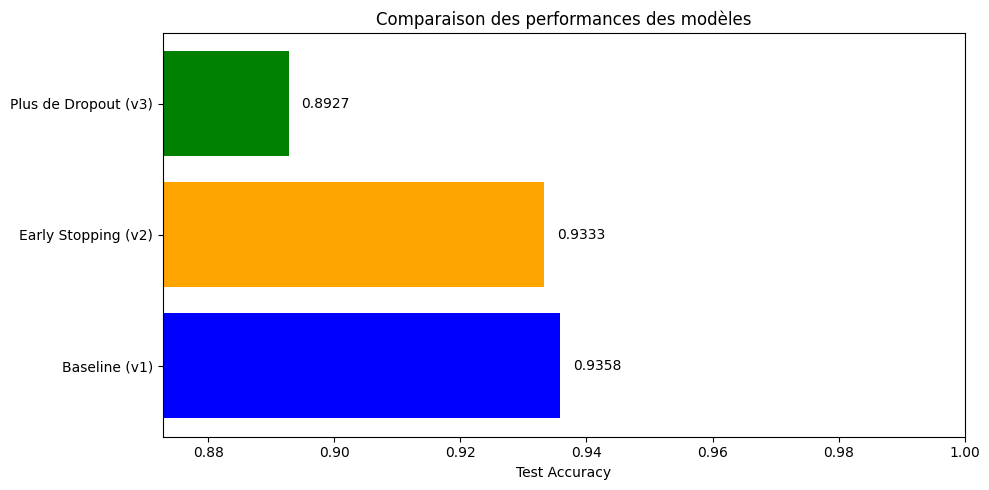

In [27]:
import pandas as pd

# Tableau récapitulatif
results_comparison = pd.DataFrame({
    'Modèle': [
        'Baseline (v1)',
        'Early Stopping (v2)',
        'Plus de Dropout (v3)'
    ],
    'Test Accuracy': [
        test_acc,
        test_acc_v2,
        test_acc_v3
    ],
    'Amélioration': [
        '—',
        f'{(test_acc_v2 - test_acc)*100:+.2f}%',
        f'{(test_acc_v3 - test_acc)*100:+.2f}%'
    ]
})

print("\n" + "="*60)
print("COMPARAISON DES MODÈLES")
print(results_comparison.to_string(index=False))

# Identifier le meilleur
best_model = results_comparison.loc[results_comparison['Test Accuracy'].idxmax()]
print(f"\n🏆 Meilleur modèle : {best_model['Modèle']}")
print(f"   Test Accuracy : {best_model['Test Accuracy']:.4f}")

# Graphique de comparaison
plt.figure(figsize=(10, 5))
colors = ['blue', 'orange', 'green']
bars = plt.barh(results_comparison['Modèle'], 
                results_comparison['Test Accuracy'],
                color=colors)

plt.xlabel('Test Accuracy')
plt.title('Comparaison des performances des modèles')

# Ajuster l'échelle automatiquement
min_acc = results_comparison['Test Accuracy'].min()
plt.xlim(min_acc - 0.02, 1.0)  # ← Adapte selon la valeur minimale

# Ajouter les valeurs sur les barres
for i, (bar, acc) in enumerate(zip(bars, results_comparison['Test Accuracy'])):
    plt.text(acc + 0.002, i, f'{acc:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

7.6 Enregistrement du modèle

In [25]:

# Identifier le meilleur modèle
best_acc = max(test_acc, test_acc_v2, test_acc_v3)

if best_acc == test_acc:
    best_model_to_save = model
    best_name = "baseline_v1"
elif best_acc == test_acc_v2:
    best_model_to_save = model  # Early stopping a modifié model en place
    best_name = "early_stopping_v2"
else:
    best_model_to_save = model_v3
    best_name = "dropout_v3"

# Sauvegarder le modèle
model_path = f"mushroom_deep_learning.keras"
best_model_to_save.save(model_path)

print(f"\nModèle sauvegardé : {model_path}")
print(f"   Accuracy : {best_acc:.4f}")


Modèle sauvegardé : mushroom_deep_learning.keras
   Accuracy : 0.9358
